In [1]:
import math
import numpy as np
import pandas as pd
import ortools 
import itertools

import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import scipy.optimize as opt
#from matplotlib import *
import plotly.express as pe

from typing import Generator, List, Tuple

# look at all possible cut assignments that result in the needed quantities
#   minimize over all of the cut assignments
from ortools.sat.python import cp_model
from ortools.linear_solver import pywraplp

In [2]:
# Let's read in the file
# We pass the paramter `header=None` to indicate that there is no header in the file
df = pd.read_csv("Harkers_Deck_1-7_EB1-RAW.csv", header=None)



In [3]:
df.columns = ["dia","Angle","length","Length2","Length3","quantity"] 

#  sample of the data looks like.
df.head()

,dia,Angle,length,Length2,Length3,quantity
0,5,0,100,0,0,14
1,5,0,105,0,0,76
2,5,0,107,0,0,12
3,5,0,118,0,0,12
4,5,0,122,0,0,6


In [4]:
# The Angle field has some string values, so pandas has coerced the whole column to strings.
df["Angle"].values

# Let's coerce all of the letters in the Angle Column to NaN (the canonical missing type)
#  We'll then make the column a column of integers
# Here, we use .loc to subset by a boolean series, and then assign to the view of the subsetted frame
df.loc[df["Angle"] == "U", "Angle"] = np.nan
df.loc[df["Angle"] == "Ux", "Angle"] = np.nan
df.loc[df["Angle"] == "U*", "Angle"] = np.nan
df.loc[df["Angle"] == "S", "Angle"] = np.nan
df.loc[df["Angle"] == "H", "Angle"] = np.nan

df["Angle"] = df["Angle"].astype(float)

df["Angle"].values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [5]:
# We can now subset to only things that are angle 0 (straight bars)
#  I tend to explictily copy whenever subsetting and assigning to a new frame. There are some quirks that can come
#  about if you do not do this.
df_straight = df[df["Angle"] == 0].copy() 

In [6]:
# For the remaining parts of this task, we can use groupby which lets us operate on grouped data
#  Here we group by ["dia", "Length", "Quantity"]
#   and add a new column that tells us how many time that group appears.d.
df_deduped = (
    df_straight
    .assign(number_of_dupes=1)
    .groupby(["dia", "length", "quantity"])
    .agg(
        number_of_dupes=pd.NamedAgg("number_of_dupes", "sum")
    )
    .reset_index(drop=False)
)

In [7]:
# Alternatively, if each record in this dataframe represents an honest-to-goodness order, we'll need to sum up the quantity
#  along each of the quantities
df_agg = (
    df_straight
    .assign(number_of_orders=1)
    .groupby(["dia", "length"])
    .agg(
        quantity=pd.NamedAgg("quantity", "sum"),
        number_of_orders=pd.NamedAgg("number_of_orders", "sum")
    )
    .reset_index(drop=False)
)

In [8]:
df_agg["quantity"] = df_agg["quantity"].astype(int)
df_agg["length"] = df_agg["length"].astype(int)

In [9]:
# This is where we subset if we want to set a hard cap on the max length we're willing to optimize
length_cutoff_feet = 20

#what is too long to fit on a truck or do our dist partners not have and will need to be further discussed
df_long = df_agg[
    (df_agg["length"]/12) > length_cutoff_feet
]
#members that work
df_short = df_agg[
    (df_agg["length"] / 12) <= length_cutoff_feet
].copy()




In [10]:
#now lets go throught the quants and separate out what needs solved and what is long enough to run as it's own skew
#known cavity minimums:
#PB3 = 32
#MB3 = 24
#PB4 = 28
#MB4 = 24
#PB5 = 22
#MB5 = 20
#MB6 = 12
#MB7 = 9
#MB8 = 8


unique_quant_cutoff = 500

df_unique_runs = df_short[
    (df_short["quantity"]) >= unique_quant_cutoff 
]

df_needs_solved = df_short[
    (df_short["quantity"]) < unique_quant_cutoff
].copy()

In [11]:
# Write each out group to a separate .csv
for diameter, group in df_unique_runs.groupby("dia"):
    group.to_csv(f"./unique-runs-bar-diameter-{diameter}.csv", index=False)
for diameter, group in df_needs_solved.groupby("dia"):
    group.to_csv(f"./straight-bars-diameter-{diameter}.csv", index=False)
    print(f"Bar size #{diameter} needs solved")
for diameter, group in df_long.groupby("dia"):
    group.to_csv(f"./extra-long-straight-bars-diameter-{diameter}.csv", index=False)

Bar size #5 needs solved
Bar size #8 needs solved


In [12]:
#define the range you want to check, in feet
#start with a large range and a large step, then narrow it down based upon the plot
#eventually this could be looped, but for now I dont think I've got the processing power for it
Min_stock_length_feet = 31
Min_stock_length_initial = Min_stock_length_feet*12

Max_stock_length_feet = 35
Max_stock_length = Max_stock_length_feet*12 +1

#if you find a highly efficient solution in the defined range, stop the process
break_threshold = .99 #give your machine a break for being a good boy

#you can make this into feet by setting it to 12, but my machine is a glutton for pain
increment_step = 6  #in whole inches



In [13]:
#create a rounding function that rounds the starting point up to the nearest whole incretement step number 
#ie. 38ft will become 40ft as the starting dim
#test_var = 36.667
def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier
#round_up(test_var, 0)

In [14]:
# manually input each file for each diameter output from Load and Parse CSV
#fn = "./straight-bars-diameter-5.csv"

#df = pd.read_csv(fn, header=0) 
#df

372
solver found optimal solution at 372inches for #5 bars
Stock of 31.000ft. produces a 96.94% efficient result for #5 bars
solver found optimal solution at 378inches for #5 bars
Stock of 31.500ft. produces a 96.35% efficient result for #5 bars
solver found optimal solution at 384inches for #5 bars
Stock of 32.000ft. produces a 95.07% efficient result for #5 bars
solver found optimal solution at 390inches for #5 bars
Stock of 32.500ft. produces a 93.80% efficient result for #5 bars
solver found optimal solution at 396inches for #5 bars
Stock of 33.000ft. produces a 92.17% efficient result for #5 bars
solver found optimal solution at 402inches for #5 bars
Stock of 33.500ft. produces a 96.64% efficient result for #5 bars
solver found optimal solution at 408inches for #5 bars
Stock of 34.000ft. produces a 95.48% efficient result for #5 bars
solver found optimal solution at 414inches for #5 bars
Stock of 34.500ft. produces a 95.52% efficient result for #5 bars
solver found optimal solutio

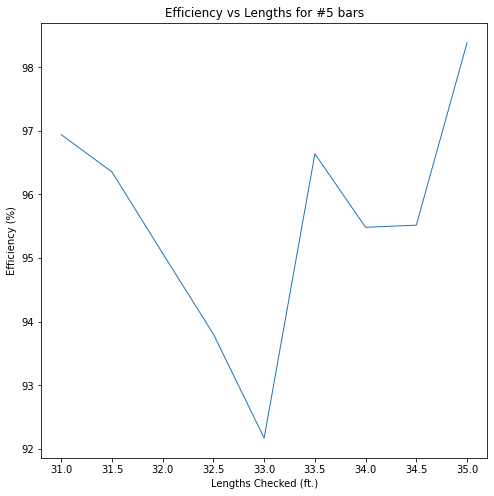

We are 98.39% efficient at 35.000ft. as a stock length for #5 bars
wrote to ./straight-bars-diameter-5-solvedV5_iterated_to_length_35.000ft.csv
372
solver found optimal solution at 372inches for #8 bars
Stock of 31.000ft. produces a 95.53% efficient result for #8 bars
solver found optimal solution at 378inches for #8 bars
Stock of 31.500ft. produces a 93.84% efficient result for #8 bars
solver found optimal solution at 384inches for #8 bars
Stock of 32.000ft. produces a 92.16% efficient result for #8 bars
solver found optimal solution at 390inches for #8 bars
Stock of 32.500ft. produces a 90.47% efficient result for #8 bars
solver found optimal solution at 396inches for #8 bars
Stock of 33.000ft. produces a 88.79% efficient result for #8 bars
solver found optimal solution at 402inches for #8 bars
Stock of 33.500ft. produces a 87.10% efficient result for #8 bars
solver found optimal solution at 408inches for #8 bars
Stock of 34.000ft. produces a 85.42% efficient result for #8 bars
solve

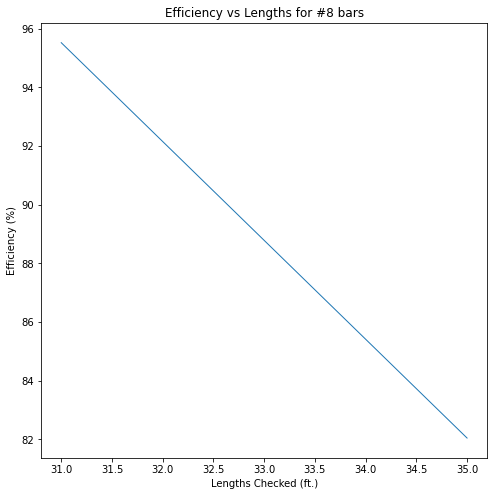

We are 95.53% efficient at 31.000ft. as a stock length for #8 bars
wrote to ./straight-bars-diameter-8-solvedV5_iterated_to_length_31.000ft.csv


In [15]:
for diameter, group in df_needs_solved.groupby("dia"):
        
    #stop the loop from going through something already solved
    
    #for z in range len(df_diameter):
        #if df_diameter[z, 1] == diameter:
            
    #if df_diameter[z, 1] == diameter:
        
        #continue
    
    #print(diameter)

    
    run_eff = 0 #counter for the end
    #plot data
    efficiency_plot = []
    stock_length_plot = []
    
    fn = f"./straight-bars-diameter-{diameter}.csv"
    #fn = f"./straight-bars-diameter-5.csv"
    #diameter = 5
    df = pd.read_csv(fn, header=0)

    #dont let the loop start off on a bad foot, check the data set to make sure things are gonna work so we dont fuck it 
    #from the start
    min_limit_state = df["length"].max() 
    
    #print(min_limit_state)

    if min_limit_state > Min_stock_length_initial:
        Min_stock_length = min_limit_state
    elif min_limit_state <240 and min_limit_state > Min_stock_length_initial:
        Min_stock_length = 240
        print(f"Concord has a manufactuting limitation of 20', this will be set to the minumum length")
    else:
        Min_stock_length = Min_stock_length_initial

    if Max_stock_length > 960:
        Max_stock_length = 961
        print(f"Concord has a manufactuting limitation of 80', this will be set to the maximum length")
    
    #use round_up to start at a whole number in feet for iteration
    Min_stock_length = Min_stock_length/12
    if increment_step >= 12 and increment_step <120:
        i = 0
        Min_stock_length = round_up(Min_stock_length, i)
        
    if increment_step >=120:
        i = -1
        Min_stock_length = round_up(Min_stock_length, i)
    
    
    
    #print(Min_stock_length)    
    
    Min_stock_length = Min_stock_length*12
    Min_stock_length = int(Min_stock_length)
    
    print(Min_stock_length)
    #total loops
    total_loops = (Max_stock_length - Min_stock_length)/increment_step

    for base_length in np.arange(Min_stock_length, Max_stock_length, increment_step):
        waste_tolerance = 0
        desired_efficiency_stopping_point = None  #.95 
        # one can set this to instruct the solver to stop after a certain efficiency is reached

        exact_cuts = df[df["length"] == base_length].copy()

        # df = df[df["length"] < base_length]
        needed_lengths = df["length"].values
        needed_quantities = df["quantity"].values

        # We expect to be allowed to make cuts
        # 
        # allowed_cuts = [
        #   (3,), (3, 3,), (3, 3, 3,), (3, 5,), (5,), (5, 3,), (5, 5,), (8,),
        # ]

        df["quantity"].sum()

        df.sort_values("length", ascending=False)

        lengths_to_quantities = {
            r["length"]: r["quantity"] for _, r in df.iterrows()
        }
        total_length_to_produce = sum(
            l * q for l, q in zip(needed_lengths, needed_quantities)
        )

        def _is_sorted(x):
            return sorted(x) == x

        def _generate_non_dominated_cuts(
            cut: List[float], 
            needed_lengths: List[float], 
            length_remaining: float, 
            tolerance_per_cut: float,
        ):  
    
            if not _is_sorted(cut):
                return
    
            if length_remaining < min(needed_lengths):
                yield cut
    
            for length in needed_lengths:
                excess = length_remaining - length - tolerance_per_cut
                if excess >= 0 or not cut:
                    yield from _generate_non_dominated_cuts(
                        cut + [length], 
                        needed_lengths, 
                        excess, 
                        tolerance_per_cut=tolerance_per_cut,
                    )
            
        def get_possible_cuts(needed_lengths: List[float], base_length: float, tolerance_per_cut: float = 0):
            assert max(needed_lengths) <= base_length
    
            return (
                tuple(x)
                    for x in _generate_non_dominated_cuts(
                        [], 
                        needed_lengths, 
                        length_remaining=base_length,
                        tolerance_per_cut=tolerance_per_cut,
                    )
            )

        possible_cuts = list(
            get_possible_cuts(needed_lengths, base_length, tolerance_per_cut=.125)
        )


        cut_produced_quantities = {}
        for i, cut in enumerate(possible_cuts):
            for j, length in enumerate(needed_lengths):
                cut_produced_quantities[i, j] = cut.count(length)

        model = pywraplp.Solver.CreateSolver('SCIP') # cp_model.CpModel()
        naive_max_cuts = max(needed_quantities)

        cut_vars = {}
        for i, cut in enumerate(possible_cuts):
            max_needed = max(
                math.ceil(lengths_to_quantities[length] / cut_produced_quantities[i, j])
                    for j, length in enumerate(needed_lengths) if cut_produced_quantities[i, j] > 0
            )
            cut_vars[i] = model.IntVar(0, max_needed, f"Cut according to rule {cut}")

        cut_wastes = {}
        for i, cut in enumerate(possible_cuts):
            cut_wastes[i] = base_length - sum(cut)

        segments_produced = {}
        for (j, length), needed in zip(enumerate(needed_lengths), needed_quantities): 
            for i, cut in enumerate(possible_cuts):
                segments_produced[i, j] = cut_vars[i] * cut_produced_quantities[i, j]  

        # assert that we produce at least as much as we need
        for (j, length), needed in zip(enumerate(needed_lengths), needed_quantities):
            total_produced = sum(
                segments_produced[i, j] for i, _ in enumerate(possible_cuts)
            )
            model.Add(total_produced >= needed)

        # measure the amount of waste that we produced
        total_excess = []
        for (j, length), needed in zip(enumerate(needed_lengths), needed_quantities):
            produced = sum(
                segments_produced[i, j] for i, _ in enumerate(possible_cuts)
            )
            total_excess.append((produced - needed) * length)
        total_excess = sum(total_excess)

        unavoidable_waste = sum(
            var * cut_wastes[i] for i, var in cut_vars.items()
        )

        total_waste = unavoidable_waste + total_excess

        if desired_efficiency_stopping_point is not None:
            print(f"setting solver to stop if efficiency of {desired_efficiency_stopping_point*100:.2f}% is reached.")    
            model.Add(
                total_waste
                    <= int((1 - desired_efficiency_stopping_point) * total_length_to_produce)
            )
        else:
            #print(f"minimizing total waste produced by cutting process")
            model.Minimize(total_waste)

        status = model.Solve()
        if status == model.OPTIMAL:
            print(f"solver found optimal solution at {base_length}inches for #{diameter} bars")
        else: 
            raise ValueError(f"no guarantee of solution optimality at {base_length}inches for #{diameter} bars")

        solution_df = []
        for i, var in cut_vars.items():
            solution_df.append(
                {
                    "cut": possible_cuts[i],
                    "cut_idx": i,
                    # "number": solver.Value(var),
                    "number": var.solution_value(),
                }
            )

        solution_df = pd.DataFrame(solution_df)
        solution_df["waste"] = solution_df["cut_idx"].apply(cut_wastes.get)
        solution_df["total_waste"] = solution_df["waste"] * solution_df["number"]

        confirmed_counts = {}
        # confirm that we didn't fuck it
        for i, var in cut_vars.items():
            for j, length in enumerate(needed_lengths):
                # confirmed_counts[length] = confirmed_counts.get(length, 0) + cut_produced_quantities[i, j] * solver.Value(var)
                confirmed_counts[length] = confirmed_counts.get(length, 0) + cut_produced_quantities[i, j] * var.solution_value()
        
        confirmed_counts_df = pd.DataFrame(
            [{"length": length, "quantity": quantity} for length, quantity in confirmed_counts.items()]
        )

        confirmatory_df = df.merge(
            confirmed_counts_df,
            how="left",
            on="length",
            suffixes=["", "_produced_by_algorithm"],
        )

        assert (confirmatory_df["quantity"] <= confirmatory_df["quantity_produced_by_algorithm"]).all()

        confirmatory_df["excess_quantity_produced"] = (
            confirmatory_df["quantity_produced_by_algorithm"] - confirmatory_df["quantity"]
        )
        confirmatory_df["excess_length_produced"] = (
            confirmatory_df["excess_quantity_produced"] * confirmatory_df["length"]
        )

        total_waste = solution_df["total_waste"].sum() + confirmatory_df["excess_length_produced"].sum()
        total_length_needed = np.sum(df["length"] * df["quantity"])

        efficiency = 1 - total_waste / total_length_needed
        #plot efficiency vs length
        efficiency_plot.append(efficiency*100)
        stock_length_plot.append(base_length/12)
        
        print(f"Stock of {base_length /12:.3f}ft. produces a {efficiency*100:.2f}% efficient result for #{diameter} bars")
    
        if efficiency > run_eff:
            run_eff = efficiency
            opt_base_length = base_length 
            optimal_solution_df = solution_df[
                (solution_df["number"]) > 0
            ]
            #optimal_solution_df = []
            #optimal_solution_df = solution_df.copy()
            if efficiency > break_threshold:
                print(f"A >{break_threshold *100:.2f}% efficient solution has been found at {opt_base_length/12:.3f}ft. in #{diameter} bars")
                break
    if len(stock_length_plot) > 2:
        
        
        plt.figure(figsize=(8, 8))
        
        plt.plot(stock_length_plot, efficiency_plot, linewidth=1)
        plt.xlabel("Lengths Checked (ft.)")
        plt.ylabel("Efficiency (%)")
        plt.title(f"Efficiency vs Lengths for #{diameter} bars")
        plt.show()
    

    optimal_solution_df["number"].sum()

    print(f"We are {run_eff *100:.2f}% efficient at {opt_base_length /12:.3f}ft. as a stock length for #{diameter} bars")

    solved_fn = fn.replace(".csv", f"-solvedV5_iterated_to_length_{opt_base_length/12:.3f}ft.csv")

    optimal_solution_df.to_csv(solved_fn)
    print(f"wrote to {solved_fn}")

 